<a href="https://colab.research.google.com/github/TranPhu1999/Parallel_programing_face_mask_detection/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BÁO CÁO ĐỒ ÁN MÔN "LẬP TRÌNH SONG SONG ỨNG DỤNG"
### GVHD: TRẦN TRUNG KIÊN
### THỰC HIỆN: Nhóm 02
### DANH SÁCH THÀNH VIÊN
  1. 1712667 - Lê Hữu Phúc
  2. 1712664 -Trần Đức Phú
  3. 1612355 - Lê Kinh Luân



# 1. MÔ TẢ ỨNG DỤNG:


*   Tên ứng dụng: Nhận diện người đeo khẩu trang với mô hình yolov3

*   Input: Một tấm ảnh người có/ không có/ đeo sai khẩu trang
*   Output: Ảnh được đánh bounding box kèm nhãn mask/ no_mask/ incorrect_mask


*   Ý nghĩa thực tế: Khi tình hình dịch đang còn lây lan mạnh trên cả nước thì việc đeo khẩu trang ra đường thực sự là rất cần thiết vì nó không chỉ bảo vệ bản thân mà còn bảo vệ cho những người xung quanh nên việc nhận diện người đeo khẩu trang sai cách thật sự rất quan trọng


*   Ứng dụng này cần phải tăng tốc vì mô hình được huấn luyện trên một mạng convolutional neural network

**Input:**

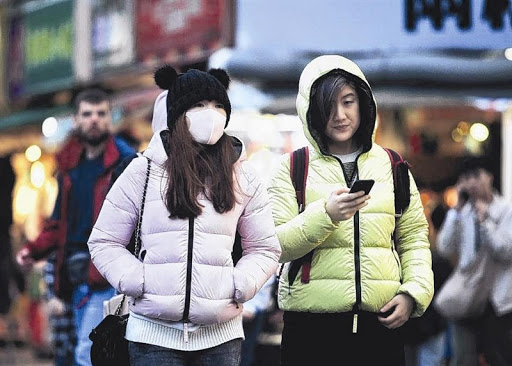

**Output:**

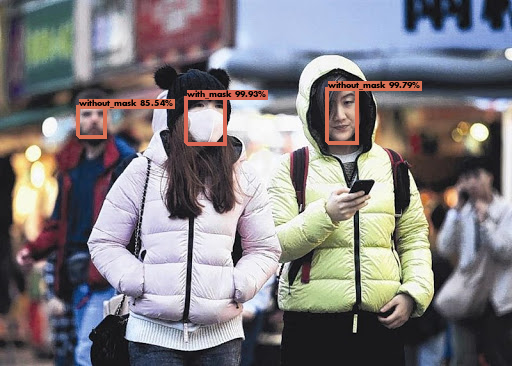

# 2. Sơ lượt về tập dữ liệu huấn luyện



*   Tập dữ liệu **Face Mask Detection** được lấy từ Kaggle. Để biết thêm về bộ dữ liệu xin hãy nhấn vào [đây](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)

*   Tập dữ liệu này chứa 853 hình ảnh thuộc 3 lớp: Đeo khẩu trang, không đeo khẩu trang và đeo khẩu trang sai.



# 3. TUẦN TỰ

## 3.1. Phân tích và thiết kế
* **Worklflow:**



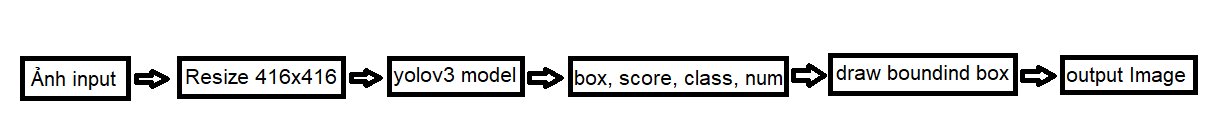

* **Output của mô hình YOLO:**

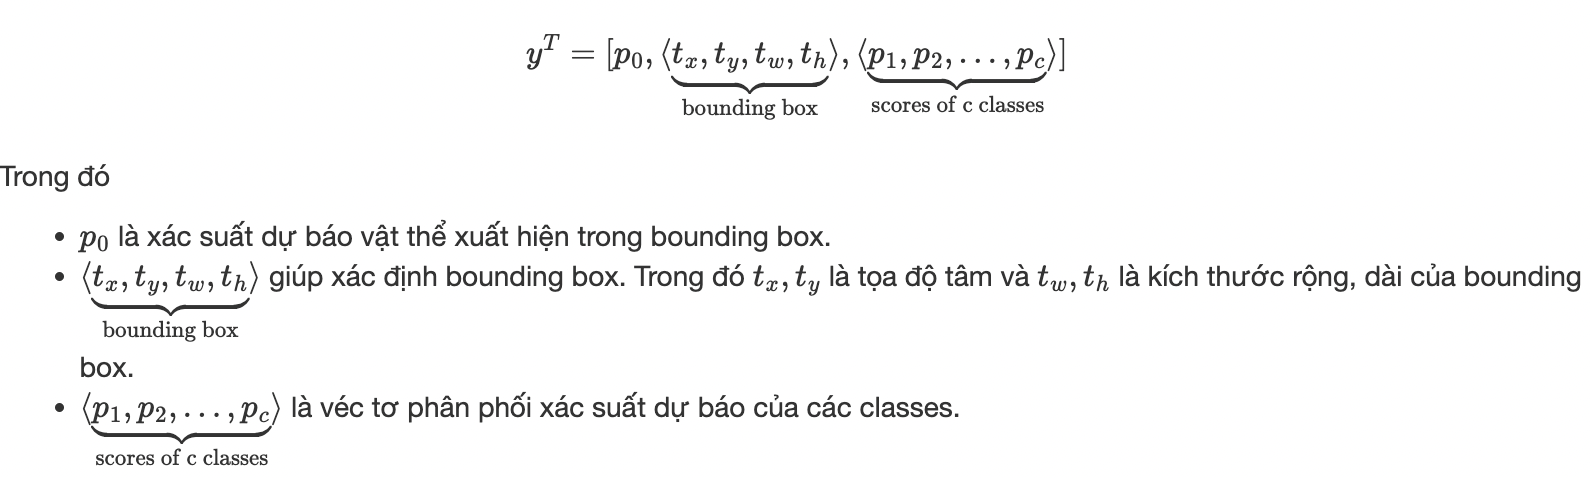

* **Công thức tính số output của mô hình YOLO:**

        (n_class + 5) * số lượng anchor boxes trên 1 cell


* **Cấu trúc yolov3:**

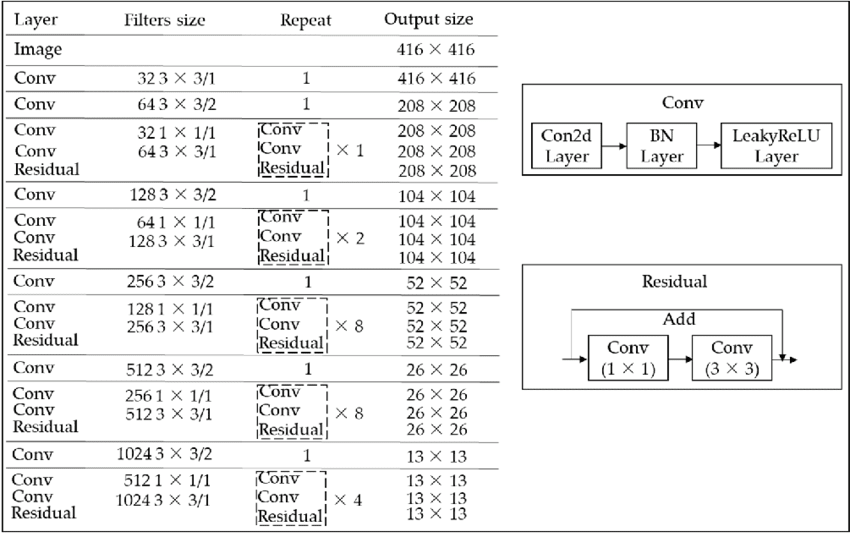

## 3.2. Code tuần tự

In [ ]:
import numba
from absl import flags
from absl.flags import FLAGS
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)


In [ ]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    Make trainable=False freeze BN for real (the og version is sad)
    """

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yolo_max_boxes = 100
yolo_iou_threshold = 0.5
yolo_score_threshold = 0.5
# customize model through the following parameters
flags.DEFINE_integer('yolo_max_boxes', 10, 'maximum number of detections at one time')
flags.DEFINE_float('yolo_iou_threshold', 0.5, 'iou threshold')
flags.DEFINE_float('yolo_score_threshold', 0.5, 'score threshold')

yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [ ]:
def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

In [ ]:
def DarknetConv(x, filters, size, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

In [ ]:
def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x

In [ ]:
def DarknetBlock(x, filters, blocks):
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

In [ ]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs, (x_36, x_61, x), name=name)

In [ ]:
def YoloConv(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

In [ ]:
def YoloOutput(filters, anchors, classes, name=None):
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

In [ ]:
def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

In [ ]:
def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=yolo_max_boxes,
        max_total_size=yolo_max_boxes,
        iou_threshold=yolo_iou_threshold,
        score_threshold=yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if len(physical_devices) > 0:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    x = inputs = Input([size, size, channels], name='input')

    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)

    outputs = Lambda(lambda x: yolo_nms(x, anchors, masks, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

In [ ]:
def return_image(filename):    

    import time
    import cv2
    img_raw = tf.image.decode_image(
        open(filename, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, size)
    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    print('time: {}'.format(t2 - t1))

    print('detections:')

    class_names_local = class_names
        
    for i in range(nums[0]):
        print('\t{}, {}, {}'.format(class_names_local[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names_local)
    
    return img

In [ ]:
print('loading model...')
classes_path = "/content/drive/MyDrive/Tài liệu các môn học /Lập trình song song ứng dụng/Lập trình song song ứng dụng/yolo_mask.names"
weights_path = "/content/drive/MyDrive/Tài liệu các môn học /Lập trình song song ứng dụng/Lập trình song song ứng dụng/yolov3_mask.tf"
num_classes = 3            # number of classes in model
yolo = YoloV3(classes=num_classes)    
yolo.load_weights(weights_path).expect_partial()
print('weights loaded')

loading model...
weights loaded


# 4. Tài liệu tham khảo



1.   https://dev.to/afrozchakure/all-you-need-to-know-about-yolo-v3-you-only-look-once-e4m#:~:text=Regarding%20the%20architecture%3A,underlying%20architecture%20for%20YOLO%20v3.
2.   https://phamdinhkhanh.github.io/2020/03/09/DarknetAlgorithm.html#:~:text=H%C3%ACnh%204%3A%20C%C3%A1c%20feature%20maps,l%C3%A0%2013x13%20%2C%2026x26%20v%C3%A0%2052x52%20.

